In [1]:
import pandas as pd
import numpy as np
import os
import shutil

import matplotlib.pyplot as plt
# import seaborn as sns
import matplotlib as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error


from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score
from itertools import product
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


from scipy.stats import kstest, shapiro


from prophet import Prophet
import cmdstanpy
cmdstanpy.install_cmdstan(compiler=True)

C:\Users\whiter04\Anaconda3\envs\prophet\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
10:12:07 - cmdstanpy - INFO - Add C++ toolchain to $PATH: C:\Users\whiter04\.cmdstan\RTools40


Installing CmdStan version: 2.35.0
Install directory: C:\Users\whiter04\.cmdstan
CmdStan version 2.35.0 already installed


True

In [2]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

In [3]:
def moving_average(data, window=5):
    return data.rolling(window=window).mean()

In [4]:
# Read CSV and drop redundant columns

df = pd.read_csv(r'C:\Users\whiter04\OneDrive - Johnson Matthey\00. cspark\ELY\ELY-TimeSeries\Data\master_data_frame.csv')
df_copy = df.copy()
df_copy = df_copy.drop('Unnamed: 0',axis=1) 


to_drop = ['temp_anode_inlet_set', 'temp_cathode_inlet_set', 'pressure_anode_set',
           'pressure_cathode_set', 'flow_anode_di_water_supply_set', 'flow_cathode_di_water_supply_set', 
          'flow_cathode_di_water_supply', 'signal_in_o2_in_h2_sensor']

df_copy = df_copy.drop(to_drop, axis=1)




# agregate into different time quanta?


df_copy['minutes'] = ((df_copy['time_running_total']/1000)/60).astype(int)
df_copy['hours'] = (df_copy['minutes']/60).astype(int)
df_copy['days'] = (df_copy['hours']/24).astype(int)
df_copy['weeks'] = (df_copy['days']/7).astype(int)
df_copy = df_copy.drop('time_running_total',axis=1)

df_copy


,cell_voltage_001,current,current_density,temp_anode_inlet,temp_anode_outlet,temp_cathode_inlet,temp_cathode_outlet,pressure_anode_inlet,pressure_anode_outlet,pressure_cathode_inlet,pressure_cathode_outlet,flow_anode_di_water_supply,signal_in_resistivity_anode,signal_in_resistivity_cathode,signal_in_h2_in_o2_sensor,minutes,hours,days,weeks
0,-0.095167,-0.01262,-0.000505,22.524658,22.211363,22.943993,22.664978,0.015911,-0.026205,-0.009285,-0.009439,0.149858,0.142337,0.580925,0.278146,0,0,0,0
1,-0.095167,-0.01262,-0.000505,22.524658,22.211363,22.943993,22.664978,0.015911,-0.026205,-0.009285,-0.009439,0.149858,0.142337,0.580925,0.278146,0,0,0,0
2,-0.095167,-0.01262,-0.000505,22.524658,22.211363,22.943993,22.664978,0.015911,-0.026205,-0.009285,-0.009439,0.149858,0.142337,0.580925,0.278146,0,0,0,0
3,-0.095167,-0.01192,-0.000477,23.574999,22.622944,22.930300,22.651320,0.184089,-0.026205,-0.009285,-0.001021,0.270174,0.132591,0.585798,0.276583,0,0,0,0
4,-0.095167,-0.01192,-0.000477,23.574999,22.622944,22.930300,22.651320,0.184089,-0.026205,-0.009285,-0.001021,0.270174,0.132591,0.585798,0.276583,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461237,1.879790,75.00482,3.000193,79.819145,78.329117,29.627552,34.574463,1.992006,1.723834,6.002450,6.019177,0.300858,0.230055,0.152083,0.104703,82242,1370,57,8
461238,1.879790,75.00482,3.000193,79.819145,78.329117,29.627552,34.574463,1.992006,1.723834,6.002450,6.019177,0.300858,0.230055,0.152083,0.104703,82242,1370,57,8
461239,1.880171,75.00482,2.999912,79.819145,78.354111,29.627552,34.560806,1.992006,1.723834,6.002450,5.960248,0.300858,0.215435,0.156957,0.103140,82243,1370,57,8
461240,1.880171,75.00482,2.999912,79.819145,78.354111,29.627552,34.560806,1.992006,1.723834,6.002450,5.960248,0.300858,0.215435,0.156957,0.103140,82243,1370,57,8


51546


,ds,y
0,2024-05-18 06:49:00,0.106265
1,2024-05-18 06:50:00,0.106265
2,2024-05-18 06:51:00,0.106265
3,2024-05-18 06:52:00,0.106265
4,2024-05-18 06:53:00,0.106265
...,...,...
51541,2024-07-05 20:59:00,0.101265
51542,2024-07-05 21:00:00,0.103140
51543,2024-07-05 21:01:00,0.103140
51544,2024-07-05 21:02:00,0.103765


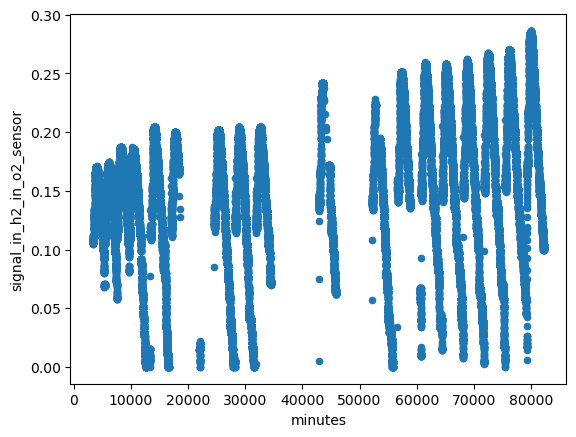

In [5]:
# time range selection

time_period = 'minutes'



df_time = df_copy.groupby(time_period).mean().reset_index()

df_time =df_time.loc[df_time['hours'] > 55]

df_time =df_time.loc[df_time['current_density'] > 0]


df_time =df_time.loc[df_time['signal_in_h2_in_o2_sensor'] > 0]

df_time.reset_index().plot(kind='scatter', x =time_period, y='signal_in_h2_in_o2_sensor')

print(len(df_time))





df_time.reset_index(inplace=True)
# df_time = df_time.drop('index',axis=1)
df_time = df_time.drop(['minutes','hours', 'days', 'weeks'],axis=1)




# df_time = df_time.rename_axis('minutes')
df_time = df_time.rename(columns={'index' : 'ds', 'signal_in_h2_in_o2_sensor':'y'})


df_time
df_time['ds'] = pd.to_datetime('2024-05-16 00:00:00') + pd.to_timedelta(df_time['ds'], unit='m')



df_time = df_time[['ds', 'y']]

data_set_base = df_time

data_set_base

In [6]:
df_time = df_time[['ds', 'y']]

df_time = df_time[df_time['ds'] > '2024-06-20 16:57:00']


def moving_average(data, window=5):
    return data.rolling(window=window).mean()


split = 0.75

n = int(len(df_time)*split)
df_t = df_time[:n]
df_eval = df_time[n:]
df_t

,ds,y
30265,2024-06-20 16:58:00,0.139079
30266,2024-06-20 16:59:00,0.135954
30267,2024-06-20 17:00:00,0.135954
30268,2024-06-20 17:01:00,0.135954
30269,2024-06-20 17:02:00,0.139079
...,...,...
46220,2024-07-02 01:06:00,0.234394
46221,2024-07-02 01:07:00,0.235332
46222,2024-07-02 01:08:00,0.234394
46223,2024-07-02 01:09:00,0.234394


In [8]:
from sklearn.model_selection import ParameterGrid


df_t = df_time[:n]
df_eval = df_time[n:]
df_t

# Define a grid of hyperparameters
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

# Generate all combinations of parameters
grid = ParameterGrid(param_grid)

# Prepare to store the results
best_params = None
best_rmse = float('inf')

# Split your data into training and validation
df_t
df_eval

# Iterate through each combination of hyperparameters
for params in grid:
    # Initialize Prophet with the current set of parameters
    model = Prophet(changepoint_prior_scale=params['changepoint_prior_scale'],
                    seasonality_prior_scale=params['seasonality_prior_scale'],
                    holidays_prior_scale=params['holidays_prior_scale'])
    
    # Fit the model on the training data
    model.fit(df_t)
    
    # Make predictions on the test set
    future = model.predict(pd.DataFrame(df_eval['ds']))
    forecast = model.predict(future)
    
    # Compute RMSE
    y_true = df_eval['y'].values
    y_pred = forecast['yhat'][-len(df_eval):].values
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # Update the best parameters if the current model is better
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

# Output the best parameters and RMSE
print(f"Best Parameters: {best_params}")
print(f"Best RMSE: {best_rmse}")

13:50:53 - cmdstanpy - INFO - Chain [1] start processing
13:50:55 - cmdstanpy - INFO - Chain [1] done processing
13:51:01 - cmdstanpy - INFO - Chain [1] start processing
13:51:02 - cmdstanpy - INFO - Chain [1] done processing
13:51:08 - cmdstanpy - INFO - Chain [1] start processing
13:51:09 - cmdstanpy - INFO - Chain [1] done processing
13:51:15 - cmdstanpy - INFO - Chain [1] start processing
13:51:17 - cmdstanpy - INFO - Chain [1] done processing
13:51:22 - cmdstanpy - INFO - Chain [1] start processing
13:51:23 - cmdstanpy - INFO - Chain [1] done processing
13:51:29 - cmdstanpy - INFO - Chain [1] start processing
13:51:30 - cmdstanpy - INFO - Chain [1] done processing
13:51:35 - cmdstanpy - INFO - Chain [1] start processing
13:51:37 - cmdstanpy - INFO - Chain [1] done processing
13:51:42 - cmdstanpy - INFO - Chain [1] start processing
13:51:43 - cmdstanpy - INFO - Chain [1] done processing
13:51:49 - cmdstanpy - INFO - Chain [1] start processing
13:51:50 - cmdstanpy - INFO - Chain [1]

Best Parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}
Best RMSE: 0.06603684030070402


14:26:25 - cmdstanpy - INFO - Chain [1] start processing
14:26:27 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\whiter04\AppData\Local\Temp\ipykernel_9628\3115846235.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  ax.plot(df_eval['ds'], df_eval['y'], 'k.', color='r');


RMSE: 0.09864921460349758
Percentage RMSE: 57.21577177991034%
r2: -1.3753211742473948


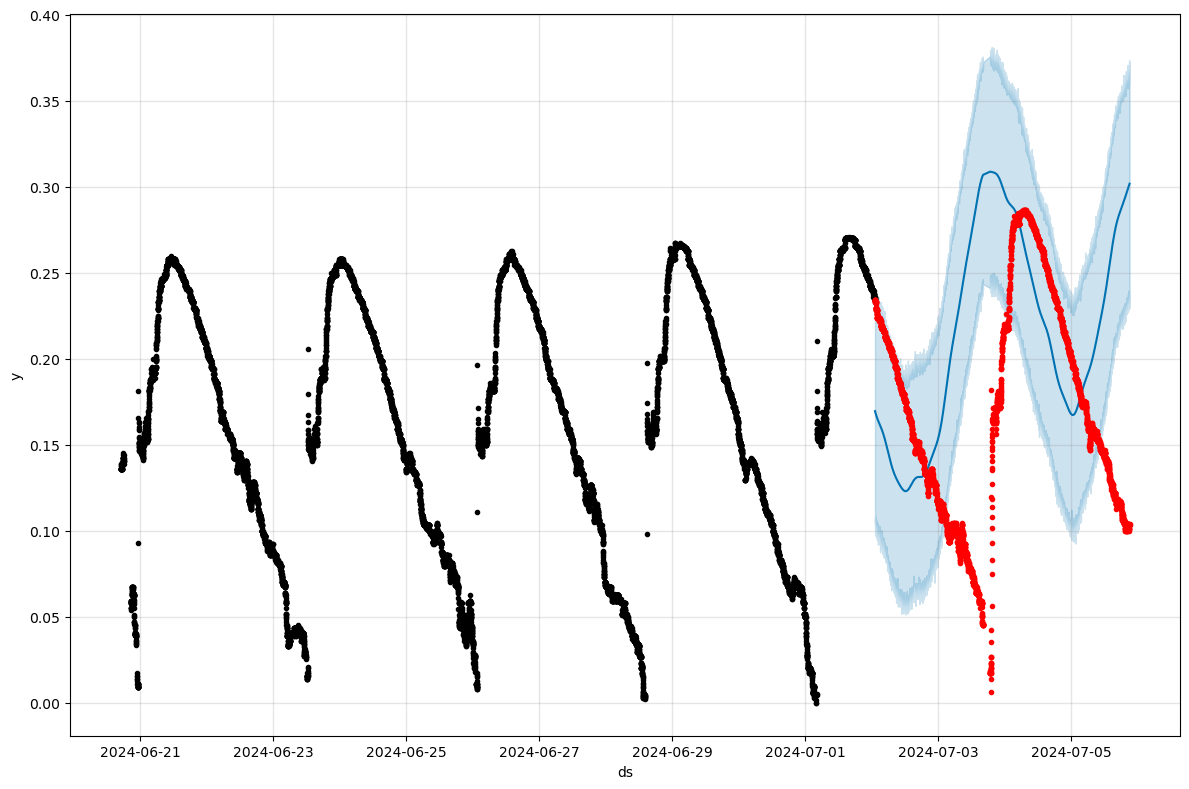

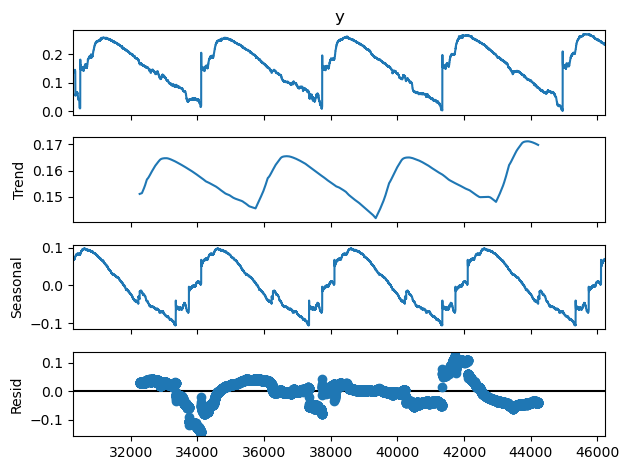

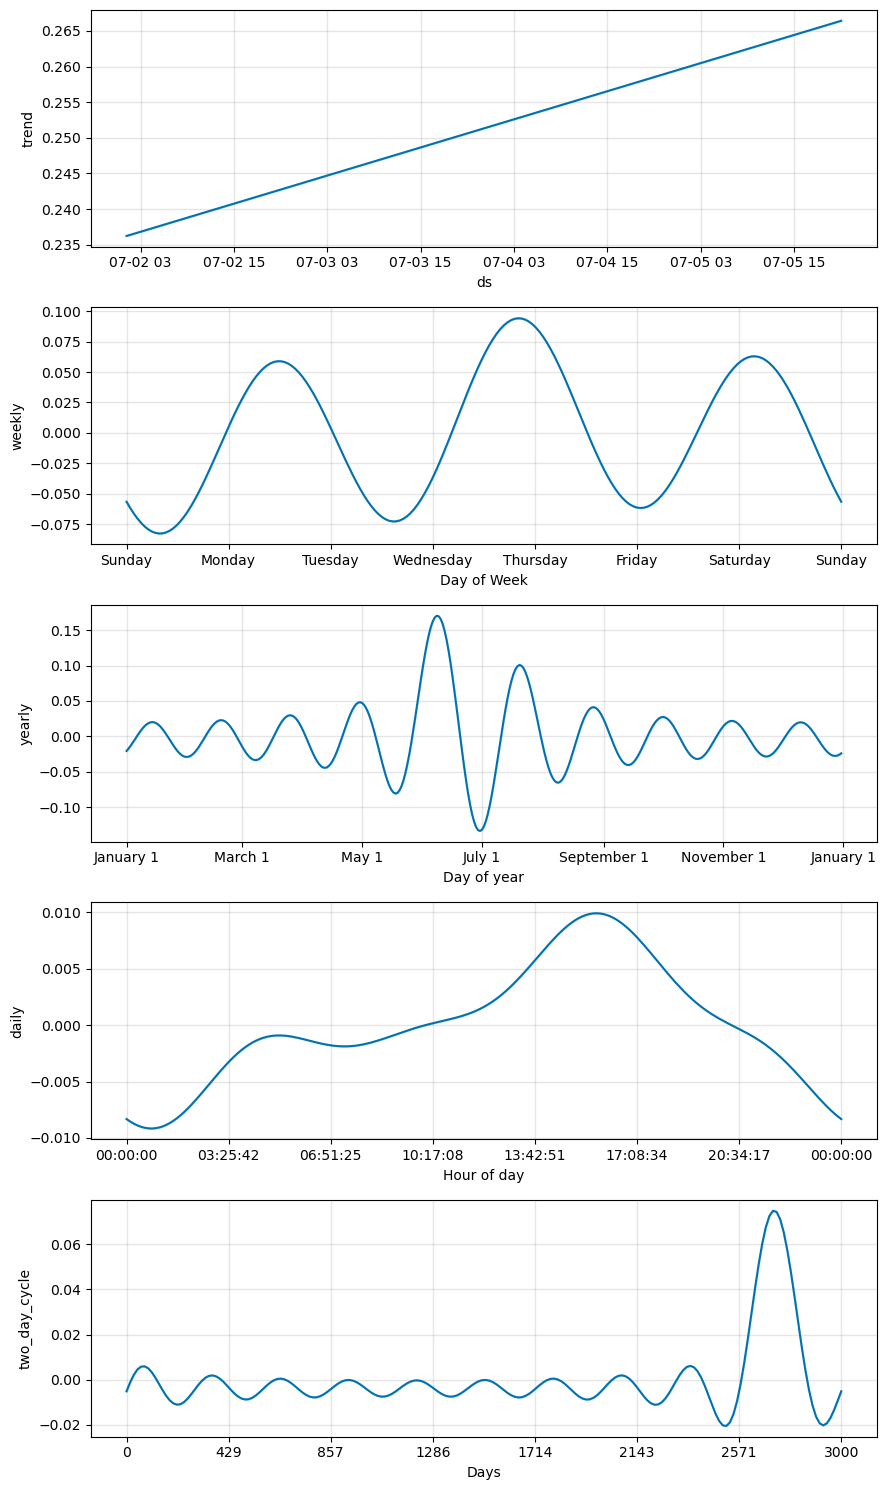

In [15]:
df_time = df_time[['ds', 'y']]

df_time = df_time[df_time['ds'] > '2024-06-20 16:57:00']


def moving_average(data, window=5):
    return data.rolling(window=window).mean()


split = 0.75

n = int(len(df_time)*split)
df_t = df_time[:n]
df_eval = df_time[n:]
df_t


model = Prophet(changepoint_prior_scale= 0.001,
                holidays_prior_scale= 0.01, 
                seasonality_prior_scale= 1.0,
                  yearly_seasonality=True,
                    weekly_seasonality=True,
                    daily_seasonality=True
)



model.add_seasonality(name='two_day_cycle', period=3000, fourier_order=10)






model.fit(df_t)
fcst = model.predict(pd.DataFrame(df_eval['ds']))


# analysis

fig = model.plot(fcst, figsize=(12,8))
ax = fig.gca()
ax.plot(df_eval['ds'], df_eval['y'], 'k.', color='r');




from sklearn.metrics import mean_squared_error



y_true = df_eval['y'].values
y_pred = fcst['yhat'].values[-len(df_eval):]

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE: {rmse}")

percentage_rmse = (rmse / df_eval['y'].mean()) * 100
print(f"Percentage RMSE: {percentage_rmse}%")





r2 = r2_score(df_eval['y'],fcst['yhat'])
print(f'r2: {r2}')







from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
# Decompose the time series
decomposition = seasonal_decompose(df_t['y'], model='additive', period=4000)

# Plot the decomposition results
decomposition.plot()
plt.show()


fig2 = model.plot_components(fcst)



In [138]:
# Extract the seasonal components
seasonal_components = fcst[['ds', 'daily', 'two_day_cycle']]

# Calculate the variance of each seasonal component
daily_variance = seasonal_components['daily'].var()
two_day_variance = seasonal_components['two_day_cycle'].var()

print(f"Daily Variance: {daily_variance}")
print(f"Two-Day Cycle Variance: {two_day_variance}")

# Compare
if daily_variance > two_day_variance:
    print("Daily seasonality is more dominant.")
else:
    print("Two-day cycle is more dominant.")


Daily Variance: 2.673370252969544e-05
Two-Day Cycle Variance: 1.7433958448941683e-06
Daily seasonality is more dominant.


14:47:44 - cmdstanpy - INFO - Chain [1] start processing
14:47:49 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.09017645223284333
Percentage RMSE: 52.30163596957234%
r2: -0.9848210920998894


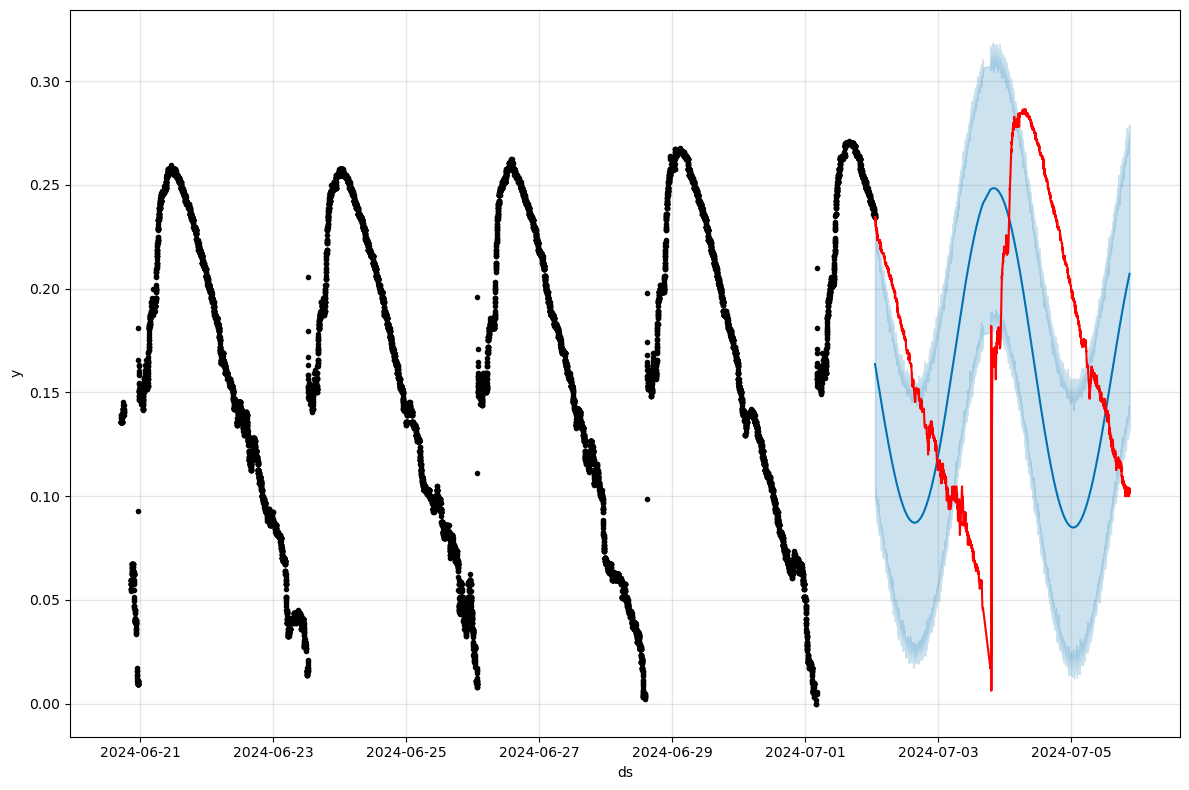

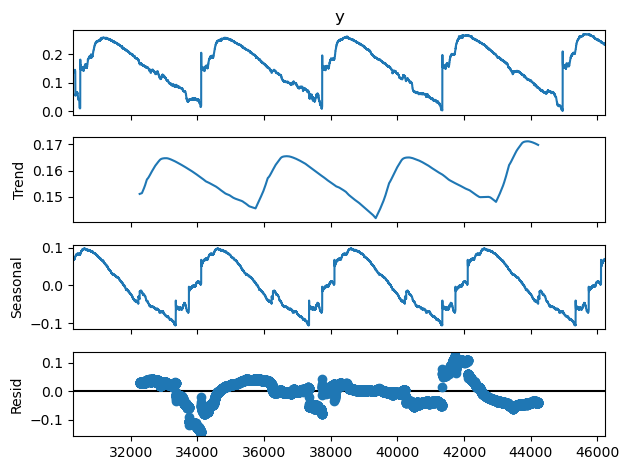

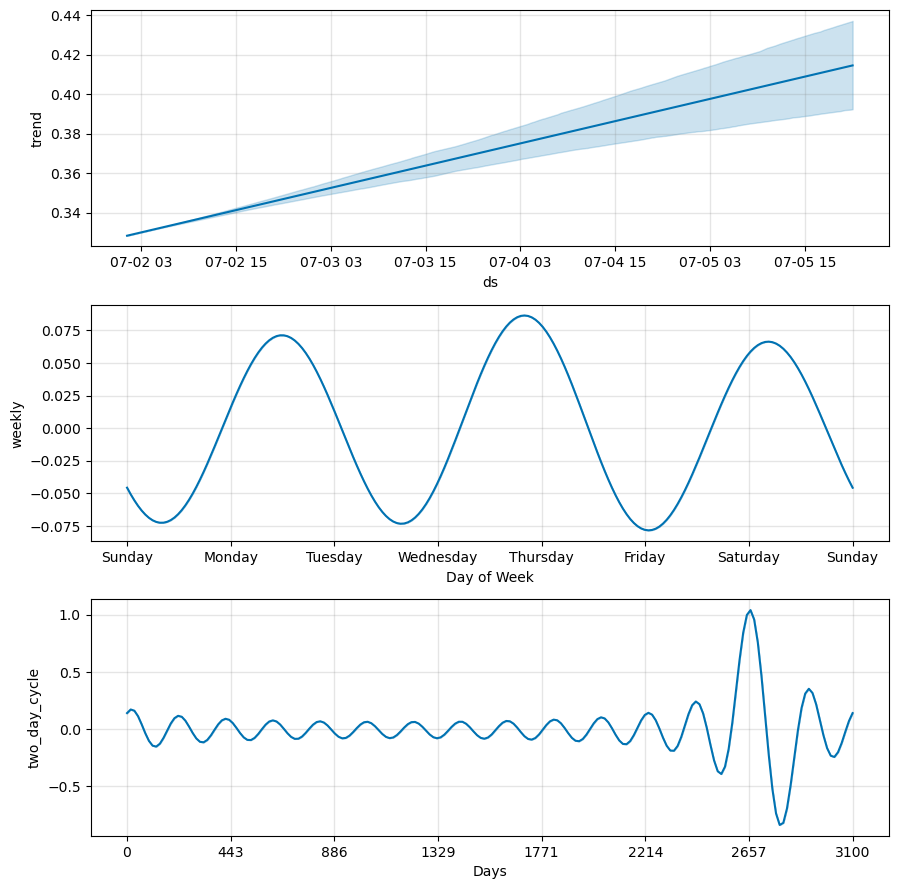

In [17]:
df_time = df_time[['ds', 'y']]

df_time = df_time[df_time['ds'] > '2024-06-20 16:57:00']


def moving_average(data, window=5):
    return data.rolling(window=window).mean()


split = 0.75

n = int(len(df_time)*split)
df_t = df_time[:n]
df_eval = df_time[n:]
df_t


model = Prophet(changepoint_prior_scale= 0.005,
                holidays_prior_scale= 0.01, 
                seasonality_prior_scale= 33.0,
                  yearly_seasonality=False,
                    weekly_seasonality=True,
                    daily_seasonality=False
)



model.add_seasonality(name='two_day_cycle', period=3100, fourier_order=15)






model.fit(df_t)
fcst = model.predict(pd.DataFrame(df_eval['ds']))




# analysis



fig = model.plot(fcst, figsize=(12,8))
ax = fig.gca()
ax.plot(df_eval['ds'], df_eval['y'], color='r');




from sklearn.metrics import mean_squared_error

y_true = df_eval['y'].values
y_pred = fcst['yhat'].values[-len(df_eval):]

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE: {rmse}")

percentage_rmse = (rmse / df_eval['y'].mean()) * 100
print(f"Percentage RMSE: {percentage_rmse}%")





r2 = r2_score(df_eval['y'],fcst['yhat'])
print(f'r2: {r2}')





from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
# Decompose the time series
decomposition = seasonal_decompose(df_t['y'], model='additive', period=4000)


# Plot the decomposition results
decomposition.plot()
plt.show()


fig2 = model.plot_components(fcst)


In [179]:
# Extract the seasonal components
seasonal_components = fcst[[
    'ds', 
                            # 'daily', 
                            'two_day_cycle', 
                            # 'weekly'
                           ]]

# Calculate the variance of each seasonal component
daily_variance = seasonal_components['daily'].var()
two_day_variance = seasonal_components['two_day_cycle'].var()
weekly_variance = seasonal_components['weekly'].var()


print(f"Daily Variance: {daily_variance}")
print(f"Two-Day Cycle Variance: {two_day_variance}")
print(f"weekly Cycle Variance: {weekly_variance}")



KeyError: 'daily'

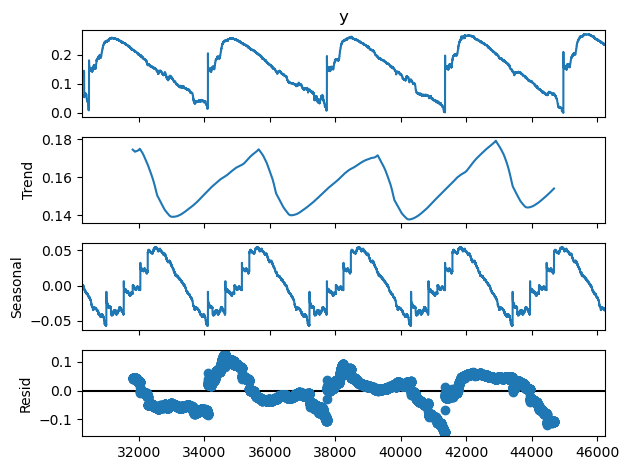

In [180]:
decomposition = seasonal_decompose(df_t['y'], model='additive', period=3100)  
decomposition.plot()
plt.show()


In [184]:
from sklearn.model_selection import ParameterGrid


df_t = df_time[:n]
df_eval = df_time[n:]
df_t

# Define a grid of hyperparameters
param_grid = {
    'changepoint_prior_scale': [0.005, 0.01, 0.05, 0.075, 1],
    'seasonality_prior_scale': [1.0, 10.0, 15, 25],
    'holidays_prior_scale': [10, 15, 20, 30],
     'yearly_seasonality' : [False,True],
    'weekly_seasonality' : [False, True],
    'daily_seasonality' : [False, True]
}

# Generate all combinations of parameters
grid = ParameterGrid(param_grid)

# Prepare to store the results
best_params = None
best_rmse = float('inf')

# Split your data into training and validation
df_t
df_eval

# Iterate through each combination of hyperparameters
for params in grid:
    # Initialize Prophet with the current set of parameters
    model = Prophet(changepoint_prior_scale=params['changepoint_prior_scale'],
                    seasonality_prior_scale=params['seasonality_prior_scale'],
                    holidays_prior_scale=params['holidays_prior_scale'],
                    yearly_seasonality=params['yearly_seasonality'],
                    weekly_seasonality=params['weekly_seasonality'],
                    daily_seasonality=params['daily_seasonality'])
    
    # Fit the model on the training data
    model.fit(df_t)
    
    # Make predictions on the test set
    future = model.predict(pd.DataFrame(df_eval['ds']))
    forecast = model.predict(future)
    
    # Compute RMSE
    y_true = df_eval['y'].values
    y_pred = forecast['yhat'][-len(test):].values
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # Update the best parameters if the current model is better
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

# Output the best parameters and RMSE
print(f"Best Parameters: {best_params}")
print(f"Best RMSE: {best_rmse}")

15:27:47 - cmdstanpy - INFO - Chain [1] start processing
15:27:49 - cmdstanpy - INFO - Chain [1] done processing
15:27:56 - cmdstanpy - INFO - Chain [1] start processing
15:27:57 - cmdstanpy - INFO - Chain [1] done processing
15:28:04 - cmdstanpy - INFO - Chain [1] start processing
15:28:09 - cmdstanpy - INFO - Chain [1] done processing
15:28:15 - cmdstanpy - INFO - Chain [1] start processing
15:28:18 - cmdstanpy - INFO - Chain [1] done processing
15:28:22 - cmdstanpy - INFO - Chain [1] start processing
15:28:25 - cmdstanpy - INFO - Chain [1] done processing
15:28:30 - cmdstanpy - INFO - Chain [1] start processing
15:28:33 - cmdstanpy - INFO - Chain [1] done processing
15:28:37 - cmdstanpy - INFO - Chain [1] start processing
15:28:40 - cmdstanpy - INFO - Chain [1] done processing
15:28:47 - cmdstanpy - INFO - Chain [1] start processing
15:28:51 - cmdstanpy - INFO - Chain [1] done processing
15:28:57 - cmdstanpy - INFO - Chain [1] start processing
15:28:59 - cmdstanpy - INFO - Chain [1]

Best Parameters: {'changepoint_prior_scale': 0.05, 'daily_seasonality': False, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 25, 'weekly_seasonality': True, 'yearly_seasonality': False}
Best RMSE: 0.05696205011675707


In [185]:
# Best Parameters: {'changepoint_prior_scale': 0.05, 'daily_seasonality': False, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 25, 'weekly_seasonality': True, 'yearly_seasonality': False}
# Best RMSE: 0.05696205011675707

In [186]:
percentage_rmse = (best_rmse / df_eval['y'].mean()) * 100
print(f"Percentage RMSE: {percentage_rmse}%")


Percentage RMSE: 33.0375429008295%


In [230]:
from skopt import gp_minimize
from skopt.space import Real, Categorical
import pandas as pd
import numpy as np


split = 0.75

n = int(len(df_time)*split)

df_t = df_time[:n]
df_eval = df_time[n:]
df_t


def objective(params):
    changepoint_prior_scale, holidays_prior_scale, seasonality_prior_scale, yearly_seasonality, weekly_seasonality, daily_seasonality, two_day_cycle_period, two_day_cycle_fourier_order = params

    try:
        model = Prophet(
            changepoint_prior_scale=changepoint_prior_scale,
            holidays_prior_scale=holidays_prior_scale,
            seasonality_prior_scale=seasonality_prior_scale,
            yearly_seasonality=yearly_seasonality,
            weekly_seasonality=weekly_seasonality,
            daily_seasonality=daily_seasonality
        )


        model.add_seasonality(
            name='custom_seasonality', 
            period=two_day_cycle_period, 
            fourier_order=two_day_cycle_fourier_order
        )


        model.fit(df_t)

        # future = model.predict(pd.DataFrame(df_eval['ds']))
        forecast = model.predict(pd.DataFrame(df_eval['ds']))
        
        # Extract and compute RMSE
        residuals = df_eval['y'].values - forecast['yhat'][-len(df_eval):].values
        rmse = np.sqrt(np.mean(residuals ** 2))

        print("Current parameters:", params)
        percentage_rmse = (rmse / df_eval['y'].mean()) * 100
        print(f"Percentage RMSE: {percentage_rmse}%")

        
        return rmse

    except Exception as e:
        print("Error:", e)
        return float("inf")

# Define search space
search_space = [
    Real(0.0001, 0.005, name='changepoint_prior_scale'),
    Real(0.01, 30, name='holidays_prior_scale'),
    Real(0.01, 30, name='seasonality_prior_scale'),
    Categorical([False, False], name='yearly_seasonality'),
    Categorical([False, True], name='weekly_seasonality'),
    Categorical([False, False], name='daily_seasonality'),
    Real(2000, 4000, name='two_day_cycle_period'),  # Adjust the range based on your requirements
    Integer(1, 35, name='two_day_cycle_fourier_order')
]

# Perform Bayesian optimization
result = gp_minimize(objective, search_space, n_calls=50, random_state=0)

print(f"Best parameters: {result.x}")
print(f"Lowest RMSE: {result.fun}")

16:07:02 - cmdstanpy - INFO - Chain [1] start processing
16:07:05 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.00300493862930259, 25.329529799944716, 25.739789072506483, False, True, False, 2595.0692130889447, 3]
Percentage RMSE: 49.63349392969763%


16:07:11 - cmdstanpy - INFO - Chain [1] start processing
16:07:15 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0014360158434425549, 14.335176868467284, 24.366940175977046, False, False, False, 2674.792320834537, 23]
Percentage RMSE: 37.59929197112511%


16:07:22 - cmdstanpy - INFO - Chain [1] start processing
16:07:25 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0019043835452186852, 28.71508321700187, 4.219119904575228, False, False, False, 3040.9549591024097, 24]
Percentage RMSE: 37.43037849646811%


16:07:38 - cmdstanpy - INFO - Chain [1] start processing
16:07:47 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0036311000081569924, 17.464773564332468, 16.125823151175833, False, False, False, 2372.66468665352, 26]
Percentage RMSE: 43.35197654509091%


16:08:04 - cmdstanpy - INFO - Chain [1] start processing
16:08:08 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0011610967366794225, 4.065193020429508, 9.73098882371849, False, False, False, 3805.1969510588096, 16]
Percentage RMSE: 37.74863348608645%


16:08:24 - cmdstanpy - INFO - Chain [1] start processing
16:08:36 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.003104010943632249, 27.071434009387794, 2.9874177072656267, False, True, False, 2716.30433393905, 27]
Percentage RMSE: 50.4610179471449%


16:08:49 - cmdstanpy - INFO - Chain [1] start processing
16:08:56 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0030783702767057924, 9.758166397960492, 1.1623785399173145, False, True, False, 3270.1177472071276, 35]
Percentage RMSE: 51.379211963143256%


16:09:04 - cmdstanpy - INFO - Chain [1] start processing
16:09:09 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0029510666142488185, 12.436913960908802, 14.246178093629505, False, False, False, 2634.4034841385924, 27]
Percentage RMSE: 39.61518508725753%


16:09:14 - cmdstanpy - INFO - Chain [1] start processing
16:09:23 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.004752898161908638, 19.87918073983183, 0.417013352007174, False, True, False, 3756.3869426943543, 18]
Percentage RMSE: 51.690867875509504%


16:09:30 - cmdstanpy - INFO - Chain [1] start processing
16:09:32 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.000373001999137871, 13.540264843482637, 0.6094300856086746, False, True, False, 2961.7870616723258, 24]
Percentage RMSE: 50.95300881701883%


16:09:46 - cmdstanpy - INFO - Chain [1] start processing
16:09:50 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0001, 9.997268955445021, 0.01, False, False, False, 2000.0, 35]
Percentage RMSE: 37.7996607395674%


16:09:54 - cmdstanpy - INFO - Chain [1] start processing
16:09:55 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0001, 30.0, 30.0, False, False, False, 2000.0, 1]
Percentage RMSE: 41.456154814020174%


16:10:03 - cmdstanpy - INFO - Chain [1] start processing
16:10:06 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0014302003496851502, 0.01, 30.0, False, False, False, 4000.0, 35]
Percentage RMSE: 37.51618331238277%


16:10:10 - cmdstanpy - INFO - Chain [1] start processing
16:10:11 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0023419137693609818, 1.2006900245086207, 14.117913573874262, False, False, False, 2099.835962168546, 2]
Percentage RMSE: 37.19948536494975%


16:10:16 - cmdstanpy - INFO - Chain [1] start processing
16:10:21 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.001943006053515011, 0.01, 0.01, False, False, False, 2000.0, 15]
Percentage RMSE: 37.4408299675751%


16:10:25 - cmdstanpy - INFO - Chain [1] start processing
16:10:27 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.004989554983486127, 22.012708615794615, 4.971528411412109, False, False, False, 3301.2400726152273, 2]
Percentage RMSE: 38.3357075699304%


16:10:34 - cmdstanpy - INFO - Chain [1] start processing
16:10:36 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0007056871374642421, 30.0, 0.01, False, False, False, 2000.0, 35]
Percentage RMSE: 37.04325903594624%


16:10:44 - cmdstanpy - INFO - Chain [1] start processing
16:10:48 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.004991312800861811, 2.866092293611087, 24.30206144432471, False, False, False, 2320.98793645807, 35]
Percentage RMSE: 43.26072951366074%


16:10:52 - cmdstanpy - INFO - Chain [1] start processing
16:10:54 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0034671198621358643, 24.924372840409262, 4.574741829465301, False, False, False, 3966.789689370395, 1]
Percentage RMSE: 37.728031096075476%


16:10:57 - cmdstanpy - INFO - Chain [1] start processing
16:10:58 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0013734998874641723, 24.990171259828323, 29.54134631160486, False, True, False, 2805.9388403671246, 1]
Percentage RMSE: 37.000692471476235%


16:11:02 - cmdstanpy - INFO - Chain [1] start processing
16:11:04 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0001, 19.708688429138356, 30.0, False, True, False, 2123.6845869511626, 7]
Percentage RMSE: 44.25547218574909%


16:11:08 - cmdstanpy - INFO - Chain [1] start processing
16:11:12 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.004990978755734128, 26.48167188511644, 0.09104369621898772, False, False, False, 2217.302572829022, 9]
Percentage RMSE: 38.558847398910245%


16:11:16 - cmdstanpy - INFO - Chain [1] start processing
16:11:18 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0033570933762324872, 20.149767234652607, 25.13508649661107, False, False, False, 3618.42696340117, 8]
Percentage RMSE: 37.43315596891495%


16:11:22 - cmdstanpy - INFO - Chain [1] start processing
16:11:25 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0004572953483578637, 17.92737945907559, 0.21398516566080109, False, False, False, 3961.1864177473026, 7]
Percentage RMSE: 37.52536135994243%


16:11:31 - cmdstanpy - INFO - Chain [1] start processing
16:11:34 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0001, 1.018194890922786, 0.01, False, False, False, 4000.0, 23]
Percentage RMSE: 39.06159473214784%


16:11:39 - cmdstanpy - INFO - Chain [1] start processing
16:11:40 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.001967579914543895, 14.61901529335634, 29.98364415703084, False, False, False, 3670.526577909769, 6]
Percentage RMSE: 37.309665488603436%


16:11:45 - cmdstanpy - INFO - Chain [1] start processing
16:11:46 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0029429452069979667, 29.054905201898702, 30.0, False, False, False, 3211.6558647886623, 1]
Percentage RMSE: 37.15951215952234%


16:11:50 - cmdstanpy - INFO - Chain [1] start processing
16:11:51 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0001, 0.01, 13.001405662903993, False, False, False, 2000.0, 3]
Percentage RMSE: 43.03443984704995%


16:11:55 - cmdstanpy - INFO - Chain [1] start processing
16:11:56 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.001088434057531473, 30.0, 0.12482289300492226, False, False, False, 4000.0, 1]
Percentage RMSE: 37.52791359116858%


16:12:01 - cmdstanpy - INFO - Chain [1] start processing
16:12:02 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0010763193310811146, 1.5944319061818806, 24.49458419584382, False, True, False, 3886.4349811268416, 1]
Percentage RMSE: 37.27020886612293%


16:12:07 - cmdstanpy - INFO - Chain [1] start processing
16:12:10 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.002675235509089727, 0.01, 10.876876612403283, False, False, False, 4000.0, 11]
Percentage RMSE: 37.02134152605267%


16:12:15 - cmdstanpy - INFO - Chain [1] start processing
16:12:16 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.000650746688766525, 30.0, 30.0, False, False, False, 2000.0, 17]
Percentage RMSE: 37.37798331383012%


16:12:24 - cmdstanpy - INFO - Chain [1] start processing
16:12:27 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0003903423678125094, 30.0, 30.0, False, False, False, 4000.0, 35]
Percentage RMSE: 37.92489132600486%


16:12:32 - cmdstanpy - INFO - Chain [1] start processing
16:12:34 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.004220831423656968, 4.631665975068757, 18.368969754907003, False, False, False, 2488.4531933749126, 1]
Percentage RMSE: 38.12445275100242%


16:12:39 - cmdstanpy - INFO - Chain [1] start processing
16:12:41 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0017187813480882327, 0.03776614498930411, 26.971752253973403, False, True, False, 2775.1174832595407, 18]
Percentage RMSE: 36.91719593006951%


16:12:46 - cmdstanpy - INFO - Chain [1] start processing
16:12:47 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0003863954604193116, 30.0, 30.0, False, True, False, 3590.75650229976, 1]
Percentage RMSE: 36.94492712078277%


16:12:54 - cmdstanpy - INFO - Chain [1] start processing
16:12:59 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.002167672884950261, 30.0, 24.644009416476965, False, False, False, 3751.261165362338, 35]
Percentage RMSE: 45.28317540416625%


16:13:06 - cmdstanpy - INFO - Chain [1] start processing
16:13:09 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.003393020028132003, 15.654971469485579, 29.39686683937988, False, True, False, 3992.512389768152, 25]
Percentage RMSE: 42.13815216738973%


16:13:19 - cmdstanpy - INFO - Chain [1] start processing
16:13:24 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0016281151408888415, 12.158719101331732, 30.0, False, True, False, 3821.9318926558362, 35]
Percentage RMSE: 45.00055797526492%


16:13:31 - cmdstanpy - INFO - Chain [1] start processing
16:13:37 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.004689312008754608, 5.897530768636498, 0.03635671961800347, False, False, False, 3714.317798159597, 35]
Percentage RMSE: 38.031545322581714%


16:13:45 - cmdstanpy - INFO - Chain [1] start processing
16:13:47 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.004561673309412459, 11.72122637256795, 0.01, False, False, False, 3860.038167157333, 1]
Percentage RMSE: 38.583244163418954%


16:13:52 - cmdstanpy - INFO - Chain [1] start processing
16:13:53 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0007499471938265328, 23.76859854822819, 29.909279200458762, False, False, False, 3439.582759897202, 1]
Percentage RMSE: 37.21525407356289%


16:13:58 - cmdstanpy - INFO - Chain [1] start processing
16:13:59 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.000417018224354548, 12.212224978504777, 24.089891449017443, False, False, False, 2065.2349826710415, 1]
Percentage RMSE: 37.48975051572915%


16:14:04 - cmdstanpy - INFO - Chain [1] start processing
16:14:07 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0005559781232000968, 19.548046152537207, 28.277323323341214, False, True, False, 3704.0584852992833, 1]
Percentage RMSE: 37.02375801580941%


16:14:13 - cmdstanpy - INFO - Chain [1] start processing
16:14:14 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0004883711572381935, 3.169578667117423, 23.3756337875698, False, True, False, 4000.0, 1]
Percentage RMSE: 37.107606604396324%


16:14:19 - cmdstanpy - INFO - Chain [1] start processing
16:14:21 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0011838281331814542, 28.38119726932208, 1.78668286733959, False, False, False, 4000.0, 1]
Percentage RMSE: 37.70237622440164%


16:14:24 - cmdstanpy - INFO - Chain [1] start processing
16:14:27 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0019279985122865274, 0.01, 0.01, False, True, False, 2226.032599092447, 1]
Percentage RMSE: 36.86388795061104%


16:14:35 - cmdstanpy - INFO - Chain [1] start processing
16:14:39 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0006044329848313995, 0.8555507570992285, 27.196028872314002, False, True, False, 3829.1956030695865, 35]
Percentage RMSE: 37.321250449953396%


16:14:46 - cmdstanpy - INFO - Chain [1] start processing
16:14:49 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0011170188296794966, 23.420325747114838, 1.9230665907667654, False, False, False, 2389.3375651880447, 31]
Percentage RMSE: 37.30184838947122%


16:14:57 - cmdstanpy - INFO - Chain [1] start processing
16:14:59 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.00028504517037275263, 26.672884325311287, 27.495020917919785, False, True, False, 2000.0, 35]
Percentage RMSE: 36.84411860720655%
Best parameters: [0.00028504517037275263, 26.672884325311287, 27.495020917919785, False, True, False, 2000.0, 35]
Lowest RMSE: 0.06352520031260397


08:41:00 - cmdstanpy - INFO - Chain [1] start processing
08:41:08 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: {'changepoint_prior_scale': 1, 'daily_seasonality': True, 'holidays_prior_scale': 30, 'seasonality_prior_scale': 25, 'weekly_seasonality': True, 'yearly_seasonality': True}
Percentage RMSE: 50.0914935721808%


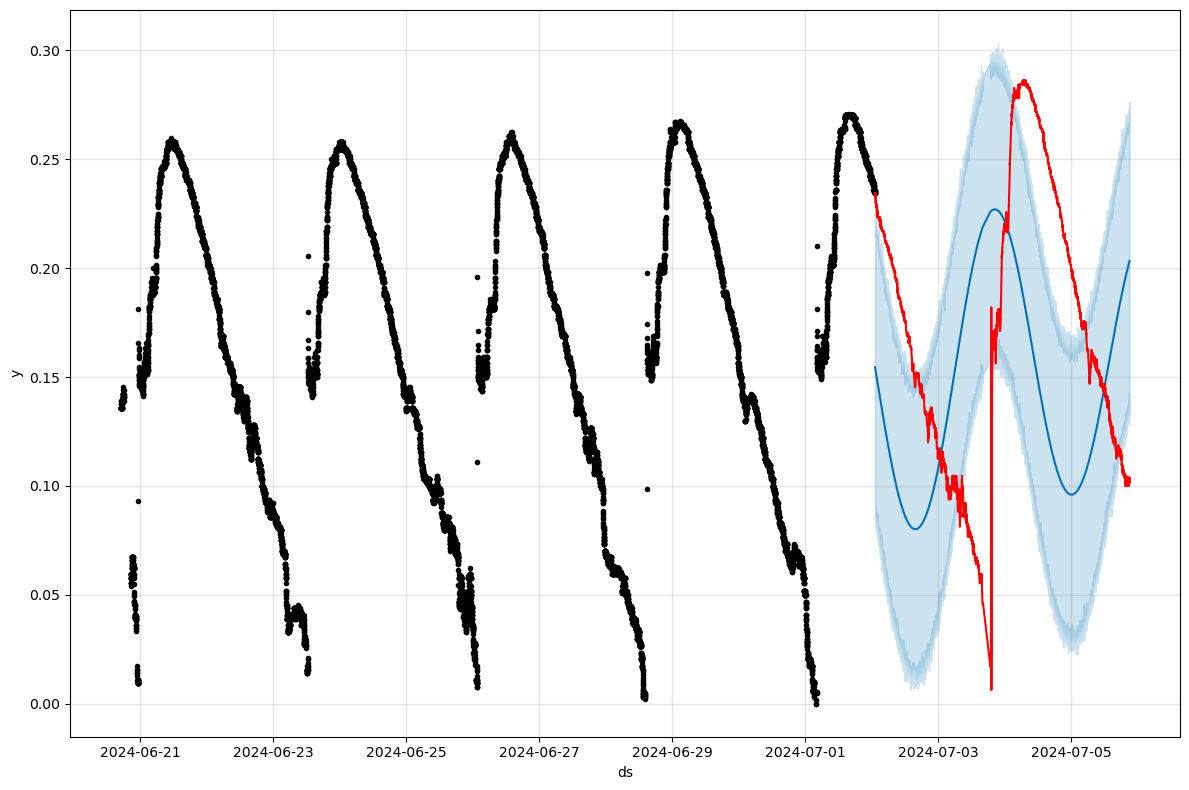

In [232]:

# Current parameters: [0.0010501500422376551, 30.0, 0.01, False, True, False]
# Percentage RMSE: 36.83629033591356%



split = 0.75

n = int(len(df_time)*split)

df_t = df_time[:n]
df_eval = df_time[n:]
df_t




model = Prophet(changepoint_prior_scale= 0.000501500422376551,
                holidays_prior_scale= 10, 
                seasonality_prior_scale= 0.01,
                  yearly_seasonality=False,
                    weekly_seasonality=True,
                    daily_seasonality=False
)



model.add_seasonality(name='two_day_cycle', period=2880, fourier_order=15)

model.fit(df_t)

# future = model.predict(pd.DataFrame(df_eval['ds']))
forecast = model.predict(pd.DataFrame(df_eval['ds']))

# Extract and compute RMSE
residuals = df_eval['y'].values - forecast['yhat'][-len(df_eval):].values
rmse = np.sqrt(np.mean(residuals ** 2))

print("Current parameters:", params)
percentage_rmse = (rmse / df_eval['y'].mean()) * 100
print(f"Percentage RMSE: {percentage_rmse}%")





fig = model.plot(forecast, figsize=(12,8))
ax = fig.gca()
ax.plot(df_eval['ds'], df_eval['y'], color='r');







In [231]:
# Best parameters: [0.00028504517037275263, 26.672884325311287, 27.495020917919785, False, True, False, 2000.0, 35]
# Lowest RMSE: 0.06352520031260397

08:43:35 - cmdstanpy - INFO - Chain [1] start processing
08:43:46 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: {'changepoint_prior_scale': 1, 'daily_seasonality': True, 'holidays_prior_scale': 30, 'seasonality_prior_scale': 25, 'weekly_seasonality': True, 'yearly_seasonality': True}
Percentage RMSE: 50.94283034462175%


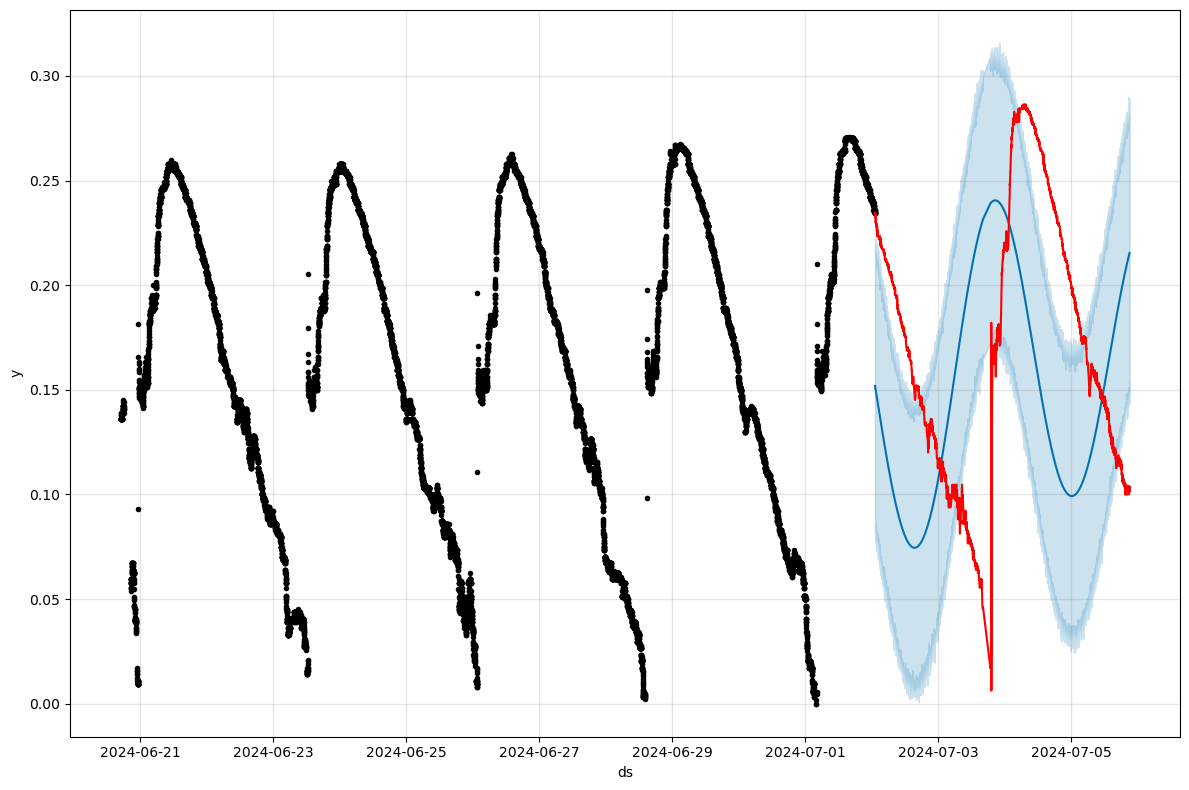

In [233]:

#  Best parameters: [0.00028504517037275263, 26.672884325311287, 27.495020917919785, False, True, False, 2000.0, 35]
# Lowest RMSE: 0.06352520031260397


split = 0.75

n = int(len(df_time)*split)

df_t = df_time[:n]
df_eval = df_time[n:]
df_t




model = Prophet(changepoint_prior_scale= 0.00028504517037275263,
                holidays_prior_scale= 26.672884325311287, 
                seasonality_prior_scale= 27.495020917919785,
                  yearly_seasonality=False,
                    weekly_seasonality=True,
                    daily_seasonality=False
)



model.add_seasonality(name='two_day_cycle', period=2000, fourier_order=35)

model.fit(df_t)

# future = model.predict(pd.DataFrame(df_eval['ds']))
forecast = model.predict(pd.DataFrame(df_eval['ds']))

# Extract and compute RMSE
residuals = df_eval['y'].values - forecast['yhat'][-len(df_eval):].values
rmse = np.sqrt(np.mean(residuals ** 2))

print("Current parameters:", params)
percentage_rmse = (rmse / df_eval['y'].mean()) * 100
print(f"Percentage RMSE: {percentage_rmse}%")





fig = model.plot(forecast, figsize=(12,8))
ax = fig.gca()
ax.plot(df_eval['ds'], df_eval['y'], color='r');





